In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse

### Labor Productivity Process
In the Aiyagari (1994) model, household (log-) labor productivity, $\varepsilon_t$, follows an AR(1) process with persistence parameter $\rho$. To simplify the model solution, we approximate the AR(1) process using a discrete Markov chain. This approximation is performed using "Tauchen's method," a standard approach for discretizing continuous state spaces. The function `approx_markov` is used to generate the corresponding Markov chain.

In [2]:
def approx_markov(rho, sigma_u, m=3, n=7):
    """
    Computes the Markov matrix associated with a discretized version of
    the linear Gaussian AR(1) process

        y_{t+1} = rho * y_t + u_{t+1}

    according to Tauchen's method.  Here {u_t} is an iid Gaussian
    process with zero mean.

    Parameters
    ----------
    rho : scalar(float)
        The autocorrelation coefficient
    sigma_u : scalar(float)
        The standard deviation of the random process
    m : scalar(int), optional(default=3)
        The number of standard deviations to approximate out to
    n : scalar(int), optional(default=7)
        The number of states to use in the approximation

    Returns
    -------

    x : array_like(float, ndim=1)
        The state space of the discretized process
    P : array_like(float, ndim=2)
        The Markov transition matrix where P[i, j] is the probability
        of transitioning from x[i] to x[j]

    """
    F = scipy.stats.norm(loc=0, scale=sigma_u).cdf

    # standard deviation of y_t
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # top of discrete state space
    x_max = m * std_y

    # bottom of discrete state space
    x_min = - x_max

    # discretized state space
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    for i in range(n):
        P[i, 0] = F(x[0]-rho * x[i] + half_step)
        P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
        for j in range(1, n-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)

    return x, P

In the next step we generate the markov chain approximation of an AR(1) process with `neta=7` realizations, persistence $\rho=0.965$, and standard deviation $\sigma=0.25$. The realizations of the shock are given by `y` and the transition matrix is given by `yprob`.

In [3]:
neta = 7 # number of realizations
rho_e = 0.965 # persistence
sig_e = 0.25 # standard deviation

# discretize the AR-process into a markov chain
y, yprob = approx_markov(rho_e, sig_e, 3, neta)

# normalization
y = np.exp(y)

Next we compute the stationary distribution of the process, and the mean labor supply under the AR(1) process.

In [4]:
# find the stationary distribution of the markov chain
S, U = scipy.linalg.eig(yprob.T)
pistar = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
pistar = pistar / np.sum(pistar)

# aggregate labor supply
var_x = sig_e**2.0 / (1.0 - rho_e**2.0)
labor = np.exp(var_x / 2.0)

### Model Setup
In this section we set the model paramteres, and we set up a grid over assets.

In [5]:
# ECONOMIC PARAMETERS

# risk aversion
gam = 2.0
# rate of depreciation
delta = 0.08
# discount factor
betta = 0.92
# capital share of income
alpha = 0.33

# GRID PARAMETERS

# number of points
na = 101
# lower bound
amin = 0.0
# upper bound
amax = 500.0

# construct grid for the household problem
agrid = np.exp(np.linspace(np.log(1+amin), np.log(1+amax), na))-1.0

### Household Problem
The solution of the household problem given an exogenous interest rate was the content of last weeks exercise. Therefore, we treat it as given today. The solution algorithm is wrapped in a Python function ``compute_pe`` that takes an interest rate as given, and return the matrix of endogenous asset states and the consumption policy on the exogenous grid. Below you find an example how to solve the household problem.

In [6]:
def compute_pe(irate):
    
    # technical parameters
    maxiter = 10000
    epsilon = 1e-7

    # calculate agg. capital and wage rate implied by the interest rate
    cap = ((labor ** (alpha - 1.0) * (delta + irate)) / alpha) ** (1.0 / (alpha - 1.0))
    wage = (1.0 - alpha) * cap ** alpha * labor ** (-alpha)

    # pre-allocation
    c_guess = np.zeros((na, neta))
    c_new = np.zeros((na, neta))
    a_endo = np.zeros((na, neta))
    a_star = np.zeros(neta)
    con = np.zeros((na, neta))
    ap = np.zeros((na, neta))

    # set a guess for the consumption policy
    for iy in range(neta):
        c_guess[:, iy] = irate * agrid + wage * y[iy]

    for iter0 in range(maxiter):

        # Step 1: Determine the grid points where the borrowing constraint is just binding
        for ia in range(na):
            for iy in range(neta):
                # Calculate the RHS of equation (5)
                rhs = betta * (1.0 + irate) * c_guess[ia, :] ** (-gam) @ np.transpose(yprob[iy, :])
                # Calculate the implied consumption (as a function of a')
                c_new[ia, iy] = rhs ** (-1.0 / gam)
                # Use the budget constraint to calculate the implied savings today (as a function of a')
                a_endo[ia, iy] = (agrid[ia] + c_new[ia, iy] - wage * y[iy]) / (1.0 + irate)

                # Calculate savings today that correspond to a choice of a'=0
                if (ia == 0):
                    a_star[iy] = a_endo[0, iy]

        # Step 2: Retrieve an updated guess for the consumption policy
        for ia in range(na):
            for iy in range(neta):
                # In this case, use the budget constraint to determine consumption
                if (agrid[ia] < a_star[iy]):
                    con[ia, iy] = (1.0 + irate) * agrid[ia] + wage * y[iy]
                    ap[ia, iy] = 0.0
                else:
                    # In this case, use linear interpolation to determine consumption
                    con[ia, iy] = np.interp(agrid[ia], a_endo[:, iy], c_new[:, iy])
                    ap[ia, iy] = (1.0 + irate) * agrid[ia] + wage * y[iy] - con[ia, iy]

        metricEGM = np.amax(np.abs(con - c_guess))

        tolEGM = epsilon * (1.0 + np.amax(np.amax(np.abs(c_guess))))

        if (metricEGM < tolEGM):
            break

        # The new guess for the consumption policy
        c_guess = np.copy(con)

    return a_endo, con

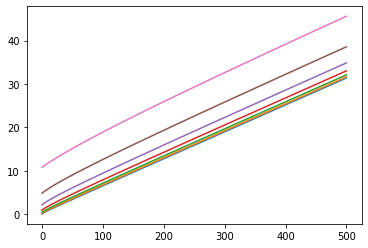

In [7]:
# EXAMPLE
irate = 0.04
a_endo, con = compute_pe(irate)

plt.figure()
for i in range(neta):
    plt.plot(agrid, con[:, i])
plt.show()

### Main Algorithm
Today's task is to compute the equilibrium interest rate. To do so we need to a) find the stationary distribution implied by households saving behavior given a guessed interest rate, and b) adjust our interest rate guess based on the excess demand of capital.

In [9]:
# set bounds for bisection algorithm
r_bracket = np.array([-delta, (1-betta) / betta])

# set an interest rate
irate = (r_bracket[0]+r_bracket[1])/2

# fine grid parameters
naf = 1000
afgrid = np.exp(np.linspace(np.log(1+amin), np.log(1+amax), naf))-1.0

maxiter = 1000
epsilon = 1e-5
for iter in range(maxiter):

    # solve the household problem
    a_endo, con = compute_pe(irate)

    # find the stationary distribution
    T = scipy.sparse.lil_matrix((naf * neta, naf * neta))
    for j in range(neta): # loop through the possible productivity states

        T_temp = scipy.sparse.lil_matrix((naf, naf))
        for i in range(naf): # loop through all grid points

            # this is the case, where the borrowing constraint is binding
            if afgrid[i] < a_endo[0, j]:
                T_temp[i, 0] = 1.0
            # this is the case where households are at the upper bound of the savings grid
            elif afgrid[i] > a_endo[na-1, j]:
                T_temp[i, naf-1] = 1.0
            # here we are somewhere inbetween
            else:
                # 1) interpolate the a' to find the corresponding choices on the finer grid
                a_endo_int = np.interp(afgrid[i], a_endo[:, j], agrid)
                # 2) determination of neighboring points and distances
                idx = np.searchsorted(afgrid, a_endo_int)-1
                weight_left = (afgrid[idx+1] - a_endo_int) / (afgrid[idx+1] - afgrid[idx])
                weight_right = 1 - weight_left
                # 3) fill up matrix
                T_temp[i, idx] = weight_left
                T_temp[i, idx+1] = weight_right

        # construct the overall transition matrix by including the transition in the exogenous state
        for k in range(neta):
            T[j*naf:naf*(j+1), k*naf:naf*(k+1)] = T_temp * yprob[j, k]

    # determine the stationary distribution by computing the eigenvector associated with the largest eigenvalue
    S, U = scipy.sparse.linalg.eigs(T.T)
    distt = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    distt = distt / np.sum(distt)

    # reshape the stationary distribution to get the PDF
    pdf = np.reshape(distt, (neta, naf)).real

    # capital implied by the interest rate
    cap = ((labor ** (alpha - 1.0) * (delta + irate)) / alpha) ** (1.0 / (alpha - 1.0))

    # determine the sum of savings held by the household sector
    sav = np.sum(afgrid * np.sum(pdf, axis=0))

    # update the interest rate guess (Bisection)
    if (cap - sav < 0.0):
        r_bracket[1] = irate
    else:
        r_bracket[0] = irate

    # Check stopping criterion:
    tolOuter = epsilon * (1.0 + np.abs(r_bracket[1]) + np.abs(r_bracket[0]))

    print('interest rate guess: ', irate * 100, ' excess demand for capital: ', cap - sav)

    if (r_bracket[1] - r_bracket[0] < tolOuter or abs(cap - sav) < epsilon):
        break

    irate = (r_bracket[0] + r_bracket[1]) / 2

interest rate guess:  0.34782608695651945  excess demand for capital:  5.0569213632568975
interest rate guess:  4.52173913043478  excess demand for capital:  -9.883999854502875
interest rate guess:  2.434782608695649  excess demand for capital:  -1.8470914252480224
interest rate guess:  1.3913043478260845  excess demand for capital:  1.5675973601086586
interest rate guess:  1.9130434782608667  excess demand for capital:  -0.1293138056310088
interest rate guess:  1.6521739130434754  excess demand for capital:  0.7191562830816398
interest rate guess:  1.782608695652171  excess demand for capital:  0.2952278948255298
interest rate guess:  1.8478260869565186  excess demand for capital:  0.08308279480294978
interest rate guess:  1.8804347826086927  excess demand for capital:  -0.023077538910738937
interest rate guess:  1.8641304347826058  excess demand for capital:  0.03001288889160847
interest rate guess:  1.8722826086956492  excess demand for capital:  0.0034698121036491614
interest rate 